In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as data
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras import layers, models, optimizers
import datetime as dt

2022-09-18 22:35:45.415193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 22:35:45.790914: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-18 22:35:45.856429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-18 22:35:45.856457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
start_date = '2002-01-01'
end_date = dt.datetime.now()

# data will be accessed using the yahoo finance api
# the company will be dependent on input, e.g. AMTD
dataframe = data.DataReader('META', 'yahoo', start_date, end_date)
dataframe.rename(columns={'Adj Close':'Adjusted_Close'}, inplace=True)
dataframe.tail()

,High,Low,Open,Close,Volume,Adjusted_Close
Date,,,,,,
2022-09-12,171.389999,167.279999,167.389999,168.960007,23220400,168.960007
2022-09-13,161.630005,152.669998,161.539993,153.130005,44444100,153.130005
2022-09-14,153.539993,149.050003,153.330002,151.470001,43064200,151.470001
2022-09-15,154.199997,148.699997,149.800003,149.550003,34606300,149.550003
2022-09-16,148.580002,144.289993,148.050003,146.289993,40018700,146.289993


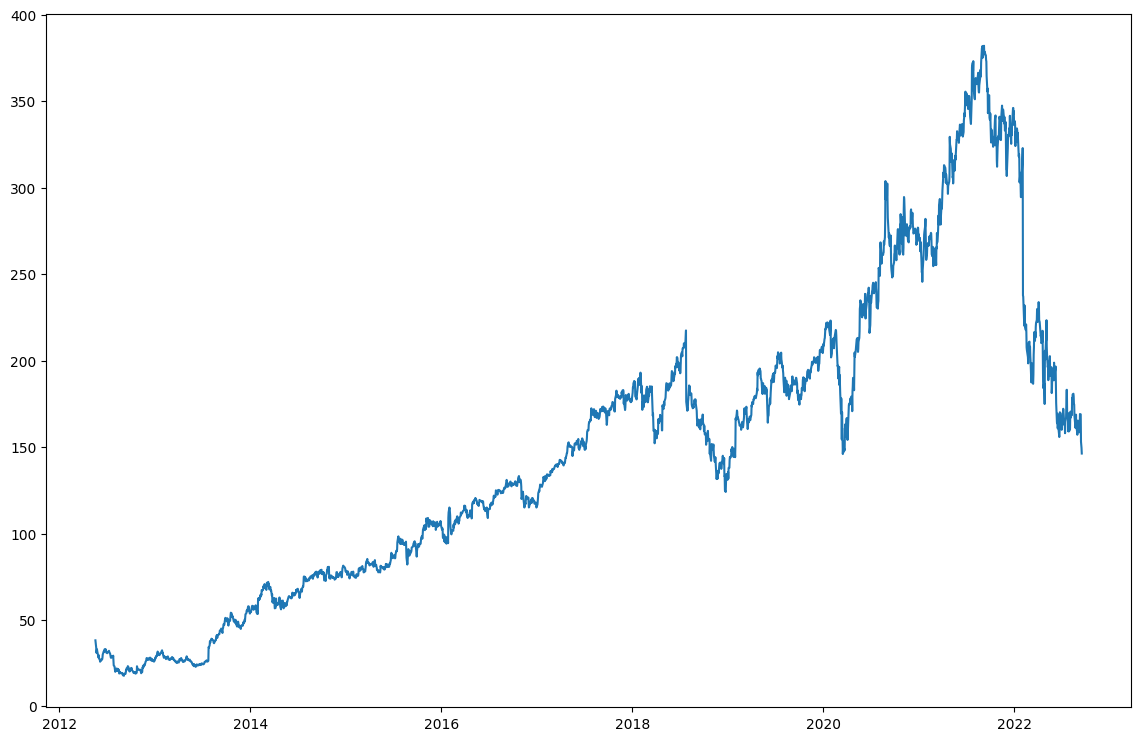

In [4]:
plt.figure(figsize=(14,9))
plt.plot(dataframe.Adjusted_Close)

In [5]:
dataframe

,High,Low,Open,Close,Volume,Adjusted_Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2022-09-12,171.389999,167.279999,167.389999,168.960007,23220400,168.960007
2022-09-13,161.630005,152.669998,161.539993,153.130005,44444100,153.130005
2022-09-14,153.539993,149.050003,153.330002,151.470001,43064200,151.470001


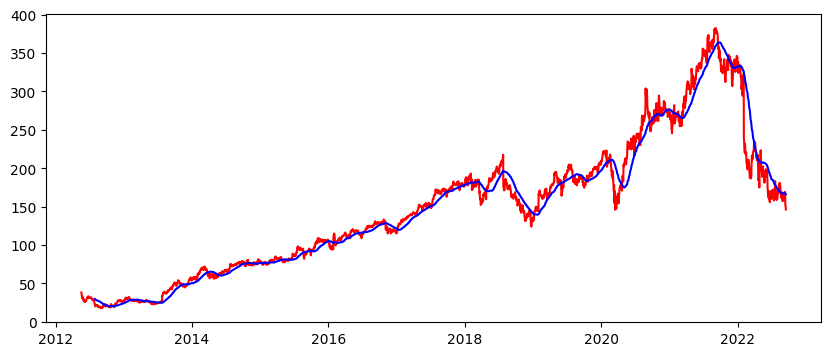

In [6]:
# a simple moving average is used to simplify the visualization of the data
# possibly dependent on the input, e.g. 50 in this case

average50 = dataframe.Adjusted_Close.rolling(50).mean()
plt.figure(figsize=(10,4))
plt.plot(dataframe.Adjusted_Close, 'r')
plt.plot(average50, 'b')

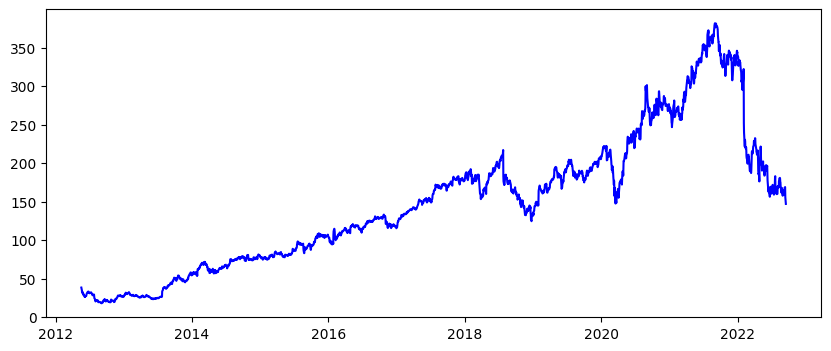

In [7]:
# exponential moving average
ema = dataframe.Adjusted_Close.ewm(com=0.2).mean() #com is the decay in terms of center of mass
plt.figure(figsize=(10,4))
plt.plot(ema, 'b')

In [8]:
# now we segregate training and testing data
# 80% of data will be used for traing the lstm model, 20% for testing
trainingData = pd.DataFrame(dataframe['Adjusted_Close'][0 : int(0.8 * len(dataframe))])

testingData = pd.DataFrame(dataframe['Adjusted_Close'][int(0.2 * len(dataframe)) : int(len(dataframe))])

In [9]:
# normalizing the data, by scaling it between 0 and 1
minMaxScaler = MinMaxScaler(feature_range=(0,1))
trainingArray = minMaxScaler.fit_transform(trainingData)

xTrain = []
yTrain = [] #array for data that is being predicted

# another input for (amount of prediction days) can used instead of 50 here
for i in range(50, len(trainingData)):
    xTrain.append(trainingArray[i - 50 : i])
    yTrain.append(trainingArray[i, 0]) #every 50 data is being predicted

# a numpy array is needed for the ml model
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

# trainingArray[0:50]
# yTrain

In [10]:
# a simple model will be used to determine the number of neurons we are working with in every layer:
# e.g. 2/3 (50 + 1) => 34 neurons per lstm layer. This shld be optimized with every layer

model = models.Sequential()

# we will use 3 lstm layers, and the dropout will increase for each layer
# relu is chosen over sigmoid for faster derivative computation
model.add(layers.LSTM(units=40, activation='relu', return_sequences=True, input_shape=(xTrain.shape[1], 1)))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(units=50, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(units=70, activation='relu'))
model.add(layers.Dropout(0.5))

#now the dense layer
model.add(layers.Dense(units=1)) #Only adjusted closing price is being predicted. This could be adapted for the user to chose what they would like to predict...

# Compiling, optimizing and calculating loss:
# As we ve a regression problem, mean_squared_error was chosen over binary_crossentropy (used typically for classification)
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['acc'])
model.fit(xTrain, yTrain, epochs=40, batch_size=32)

2022-09-18 22:35:50.691012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-18 22:35:50.691288: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-18 22:35:50.691324: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (akshat-Surface-Laptop-3): /proc/driver/nvidia/version does not exist
2022-09-18 22:35:50.692138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
64/64 [==============================] - 11s 78ms/step - loss: 0.0293 - acc: 9.8522e-04
Epoch 2/40
64/64 [==============================] - 5s 76ms/step - loss: 0.0130 - acc: 9.8522e-04
Epoch 3/40
64/64 [==============================] - 4s 67ms/step - loss: 0.0106 - acc: 9.8522e-04
Epoch 4/40
64/64 [==============================] - 4s 66ms/step - loss: 0.0084 - acc: 9.8522e-04
Epoch 5/40
64/64 [==============================] - 4s 62ms/step - loss: 0.0084 - acc: 9.8522e-04
Epoch 6/40
64/64 [==============================] - 4s 70ms/step - loss: 0.0077 - acc: 9.8522e-04
Epoch 7/40
64/64 [==============================] - 4s 69ms/step - loss: 0.0069 - acc: 9.8522e-04
Epoch 8/40
64/64 [==============================] - 4s 69ms/step - loss: 0.0061 - acc: 9.8522e-04
Epoch 9/40
64/64 [==============================] - 4s 64ms/step - loss: 0.0057 - acc: 9.8522e-04
Epoch 10/40
64/64 [==============================] - 4s 63ms/step - loss: 0.0054 - acc: 9.8522e-04
Epoch 11/40
64/64 

In [11]:
model.save('adjustedClosingPredictionModel.h5')

65/65 [==============================] - 2s 14ms/step


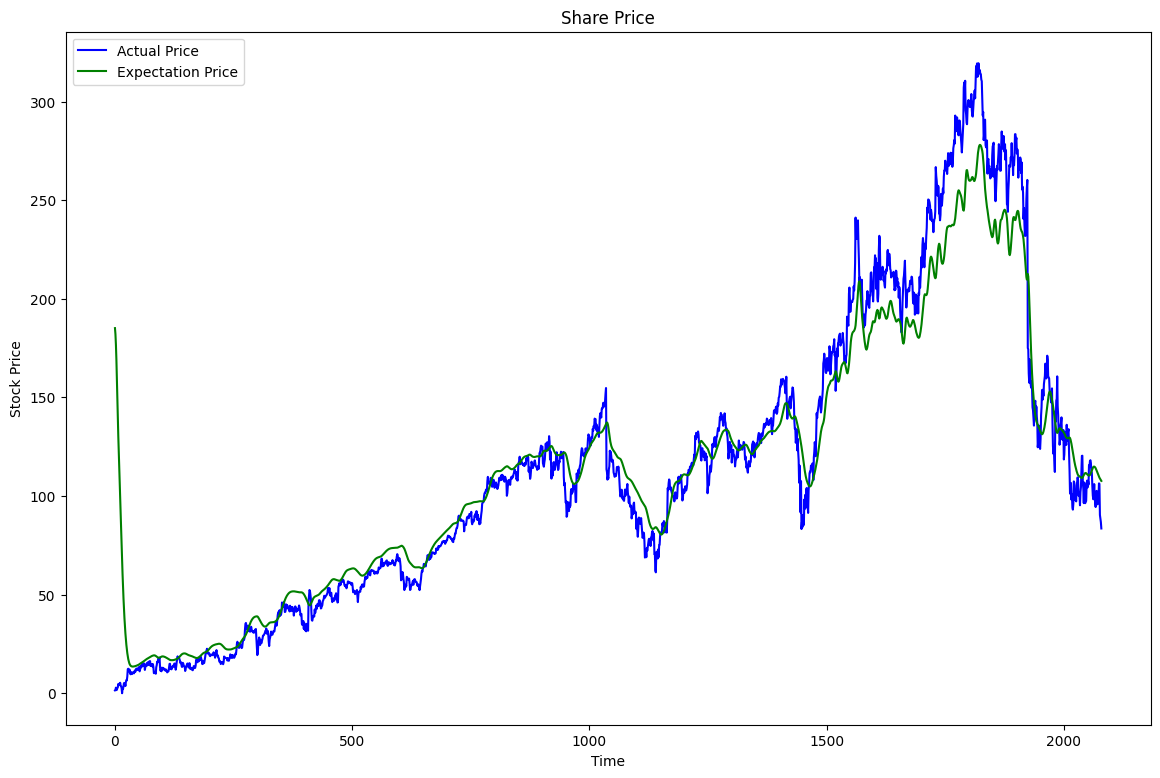

In [12]:
# Now we will test the model the accuracy of our model on the test data(in this case 20%):
# Visualize the accuracy using a graph

previousNDays = trainingData.tail(50) #n may be adapted
concatenatedDataframe = pd.concat((previousNDays, testingData), axis=0)
#normalize the concatenated data frame
inputData = minMaxScaler.fit_transform(concatenatedDataframe)

xTest = []
yTest = []

n = 0 #n is herby the amount of days in the future being predicted
for i in range(50, len(inputData) + n):
    xTest.append(inputData[i - 50 : i])
    yTest.append(inputData[i, 0])
# a numpy array for testing
xTest = np.array(xTest)
yTest = np.array(yTest)

#Now the accuracy will be verified:
yPrediction = model.predict(xTest)
scalingFactor = 1/minMaxScaler.scale_[0] # to undo normalization scale it back
yTest = scalingFactor * yTest
yPrediction = scalingFactor * yPrediction

plt.figure(figsize=(14,9))
plt.plot(yTest, color="blue", label="Actual Price")
plt.plot(yPrediction, color="green", label="Expectation Price")
plt.title("Share Price")
plt.xlabel('Time')
plt.ylabel("Stock Price")
plt.legend()

In [17]:
import datetime as dt

arr = dataframe.index.array
latestDate = arr[len(arr) - 1].to_pydatetime()
predictionDate = (latestDate + dt.timedelta(days=1)).strftime("%d.%m.%Y")

datetime.datetime(2022, 9, 18, 23, 31, 28, 267651)

In [14]:
#updating inputData
inputData = [inputData[len(inputData) - 50 + 1 : len(inputData), 0]] #by default
inputData = np.array(inputData)
#add a dimension back
inputData

array([[[0.31344314],
        [0.3146641 ],
        [0.31535286],
        [0.29832198],
        [0.31914094],
        [0.32706155],
        [0.35382882],
        [0.37671404],
        [0.3769645 ],
        [0.33344815],
        [0.32524575],
        [0.30176569],
        [0.33441865],
        [0.30668087],
        [0.3016092 ],
        [0.30420761],
        [0.30502162],
        [0.33197673],
        [0.33751804],
        [0.32668588],
        [0.3365162 ],
        [0.33113143],
        [0.36184334],
        [0.3591823 ],
        [0.36860561],
        [0.36982657],
        [0.36538102],
        [0.35091732],
        [0.35032248],
        [0.32934697],
        [0.31397535],
        [0.30790183],
        [0.31463277],
        [0.3319141 ],
        [0.30999938],
        [0.30182832],
        [0.29553568],
        [0.31359964],
        [0.3212072 ],
        [0.30542862],
        [0.29985598],
        [0.30564775],
        [0.31087597],
        [0.33307244],
        [0.33247765],
        [0

In [15]:
#future prediction:
prediction = model.predict(inputData)
scalingFactor = 1/minMaxScaler.scale_[0]
prediction = scalingFactor * prediction

print(f"prediction for next stock market day from {predictionDate} onwards: {prediction[0][0]}")

1/1 [==============================] - 0s 436ms/step
prediction for next stock market day from 17.09.2022 onwards: 107.09690856933594
